# Cross-Graph Structural Similarity

This notebook demonstrates that LSME assigns similar embeddings to **structurally equivalent nodes** across different parts of a graph.

## Key Concept

When we create multiple identical structures in different locations and connect them randomly, LSME should:
1. Recognize that corresponding nodes across structures are equivalent
2. Place them close together in embedding space
3. Enable finding "structural twins" via nearest neighbor search

This is powerful because it means the embeddings are **position-invariant** - they capture local structure, not global location.

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
import seaborn as sns

from lsme import LSME, SyntheticGraphBuilder

## 1. Create Graph with Repeated Identical Structures

We create 4 copies of each pattern type. Within each pattern type, corresponding nodes should have equivalent structural roles.

In [2]:
# Build graph with repeated identical structures
# Note: We need sufficient hydration probability to connect all patterns
# (the builder extracts the largest connected component)
builder = SyntheticGraphBuilder(random_state=42)

G = (builder
     .add_star_pattern(count=4, n_arms=5, arm_length=2)   # 4 identical stars
     .add_barbell(count=4, m1=5, m2=3)                    # 4 identical barbells
     .hydrate(prob=0.08)  # Higher prob to connect all patterns
     .build())

print(f"Nodes: {G.number_of_nodes()}")
print(f"Edges: {G.number_of_edges()}")
print(f"Connected: {nx.is_connected(G)}")

Nodes: 96
Edges: 145
Connected: True


In [3]:
# Analyze the structure types and their instance IDs
nodes = sorted(G.nodes())

def get_structure_info(node, G):
    """Get pattern type, instance ID, and role within pattern."""
    role = G.nodes[node].get('role', '')
    con_type = G.nodes[node].get('con_type', -1)
    
    if role.startswith('s'):
        pattern = 'star'
        local_role = role  # s0, s1, s2
    elif role.startswith('b'):
        pattern = 'barbell'
        local_role = role  # b0, b1, b2, b3, etc.
    else:
        pattern = 'other'
        local_role = role
    
    return pattern, con_type, local_role

# Get info for all nodes
node_info = {n: get_structure_info(n, G) for n in nodes}

# Count patterns and instances
patterns = set(info[0] for info in node_info.values())
for pattern in sorted(patterns):
    instances = set(info[1] for n, info in node_info.items() if info[0] == pattern)
    roles = set(info[2] for n, info in node_info.items() if info[0] == pattern)
    print(f"{pattern}: {len(instances)} instances, roles = {sorted(roles)}")

barbell: 2 instances, roles = ['b0', 'b1', 'b3', 'b5', 'b6']
star: 2 instances, roles = ['s0', 's1', 's2']


## 2. Visualize the Graph

Color nodes by their **instance ID** to show that identical structures are in different locations.

/var/folders/mr/8kstzll94fv16c5vmgnylb280000gn/T/ipykernel_64962/2165986883.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


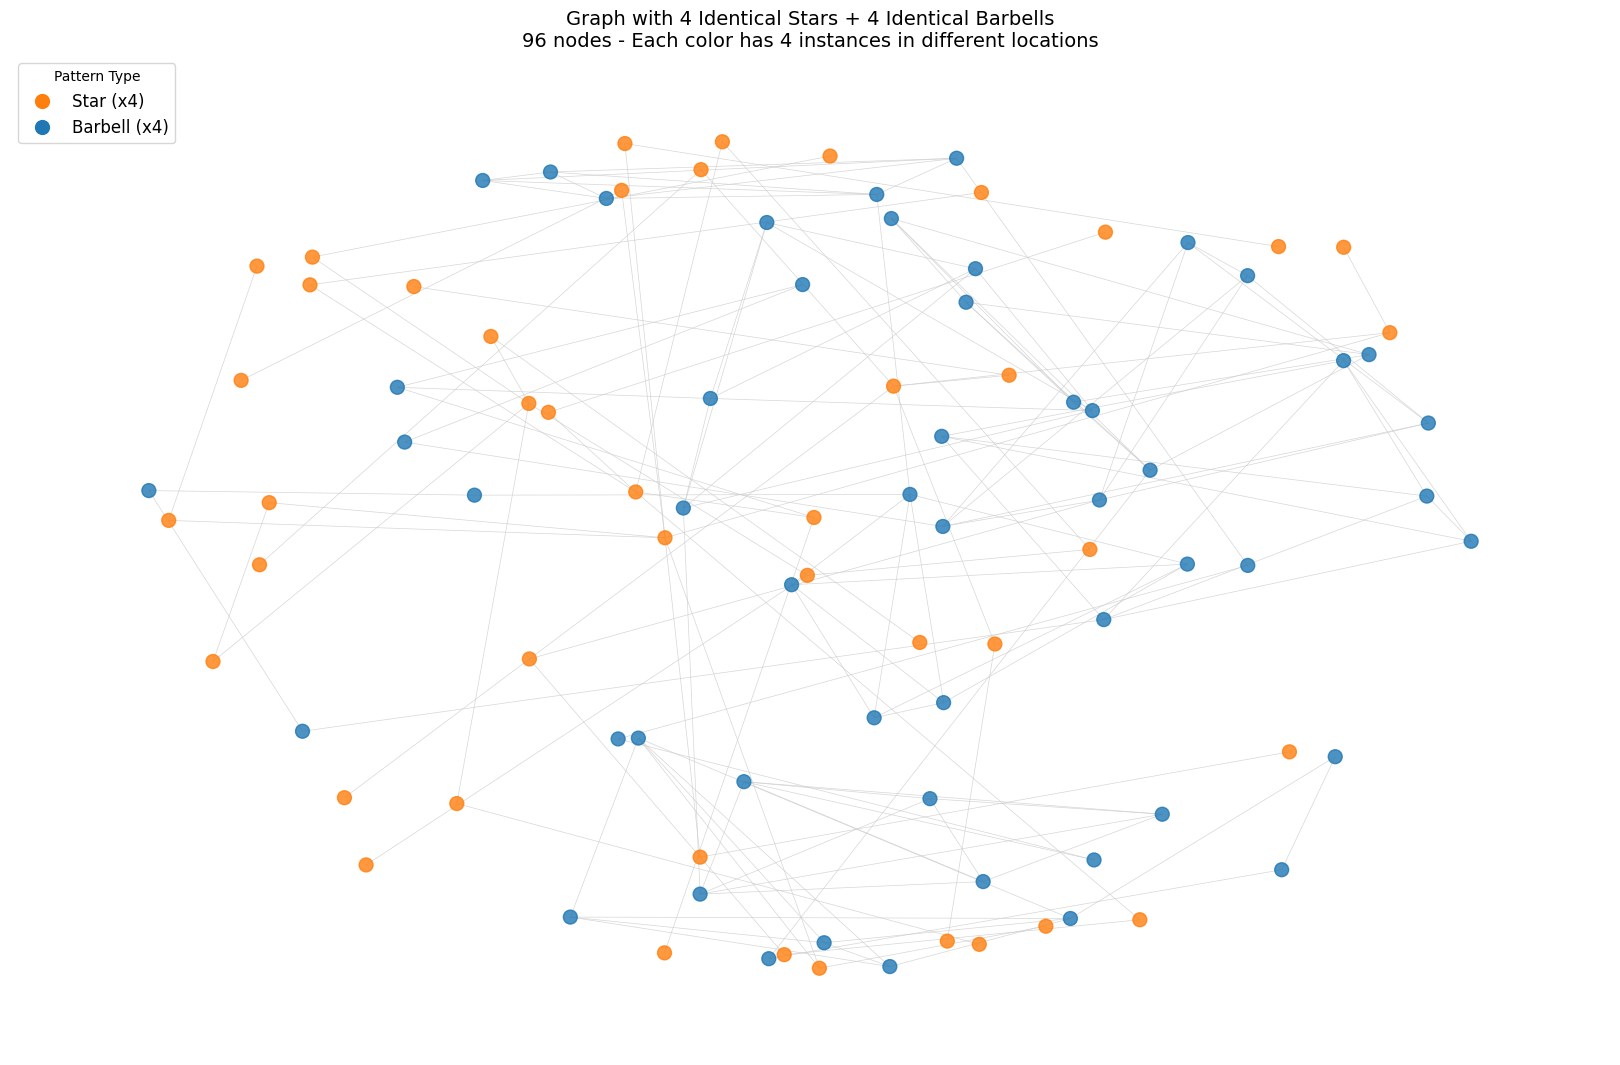

In [4]:
# Color by pattern type
PATTERN_COLORS = {
    'star': '#ff7f0e',     # Orange
    'barbell': '#1f77b4',  # Blue
    'other': '#808080'     # Gray
}

node_colors = [PATTERN_COLORS[node_info[n][0]] for n in G.nodes()]

# Create visualization
plt.figure(figsize=(16, 10))
pos = nx.spring_layout(G, seed=42, k=0.8)

nx.draw(G, pos,
        node_color=node_colors,
        node_size=100,
        alpha=0.8,
        edge_color='#cccccc',
        width=0.5)

# Add legend
handles = [plt.Line2D([0], [0], marker='o', color='w',
           markerfacecolor=c, markersize=12, label=f'{p.title()} (x4)')
           for p, c in PATTERN_COLORS.items() if p != 'other']
plt.legend(handles=handles, loc='upper left', fontsize=12, title='Pattern Type')

plt.title(f'Graph with 4 Identical Stars + 4 Identical Barbells\n'
          f'{G.number_of_nodes()} nodes - Each color has 4 instances in different locations',
          fontsize=14)
plt.tight_layout()
plt.show()

## 3. Compute LSME Embeddings

In [5]:
# Compute embeddings
lsme = LSME(
    method='stochastic',
    max_hops=3,
    n_samples=200,
    embedding_dim=64,
    encoder_epochs=100,
    verbose=True,
    random_state=42
)

result = lsme.fit_transform(G)

# Create embedding matrix
X = np.array([result['embeddings'][n] for n in nodes])
print(f"\nEmbedding shape: {X.shape}")

Computing signature for node 0 (1/96)...
Computing signature for node 1 (2/96)...
Computing signature for node 2 (3/96)...
Computing signature for node 3 (4/96)...
Computing signature for node 4 (5/96)...
Computing signature for node 5 (6/96)...
Computing signature for node 6 (7/96)...
Computing signature for node 7 (8/96)...
Computing signature for node 8 (9/96)...
Computing signature for node 9 (10/96)...
Computing signature for node 10 (11/96)...
Computing signature for node 11 (12/96)...
Computing signature for node 12 (13/96)...
Computing signature for node 13 (14/96)...
Computing signature for node 14 (15/96)...
Computing signature for node 15 (16/96)...
Computing signature for node 16 (17/96)...
Computing signature for node 17 (18/96)...
Computing signature for node 18 (19/96)...
Computing signature for node 19 (20/96)...
Computing signature for node 20 (21/96)...
Computing signature for node 21 (22/96)...
Computing signature for node 22 (23/96)...
Computing signature for node 2

Computing signature for node 70 (71/96)...


Computing signature for node 71 (72/96)...
Computing signature for node 72 (73/96)...
Computing signature for node 73 (74/96)...
Computing signature for node 74 (75/96)...
Computing signature for node 75 (76/96)...
Computing signature for node 76 (77/96)...
Computing signature for node 77 (78/96)...
Computing signature for node 78 (79/96)...
Computing signature for node 79 (80/96)...
Computing signature for node 80 (81/96)...
Computing signature for node 81 (82/96)...
Computing signature for node 82 (83/96)...
Computing signature for node 83 (84/96)...
Computing signature for node 84 (85/96)...
Computing signature for node 85 (86/96)...
Computing signature for node 86 (87/96)...
Computing signature for node 87 (88/96)...
Computing signature for node 88 (89/96)...
Computing signature for node 89 (90/96)...
Computing signature for node 90 (91/96)...
Computing signature for node 91 (92/96)...
Computing signature for node 92 (93/96)...
Computing signature for node 93 (94/96)...
Computing 

Epoch 10/100 - Train Loss: 0.029372, Val Loss: 0.068982


Epoch 20/100 - Train Loss: 0.012036, Val Loss: 0.016592


Epoch 30/100 - Train Loss: 0.006641, Val Loss: 0.009022


Epoch 40/100 - Train Loss: 0.004070, Val Loss: 0.006296


Epoch 50/100 - Train Loss: 0.002524, Val Loss: 0.005327


Epoch 60/100 - Train Loss: 0.002289, Val Loss: 0.004575


Epoch 70/100 - Train Loss: 0.001592, Val Loss: 0.004373


Epoch 80/100 - Train Loss: 0.001370, Val Loss: 0.003743


Epoch 90/100 - Train Loss: 0.001159, Val Loss: 0.003517


Epoch 100/100 - Train Loss: 0.000881, Val Loss: 0.003463
Training complete!

Embedding shape: (96, 64)


## 4. Visualize Embeddings by Local Role

If LSME captures structure correctly, nodes with the same local role (e.g., all "star centers") should cluster together, even if they're from different star instances.

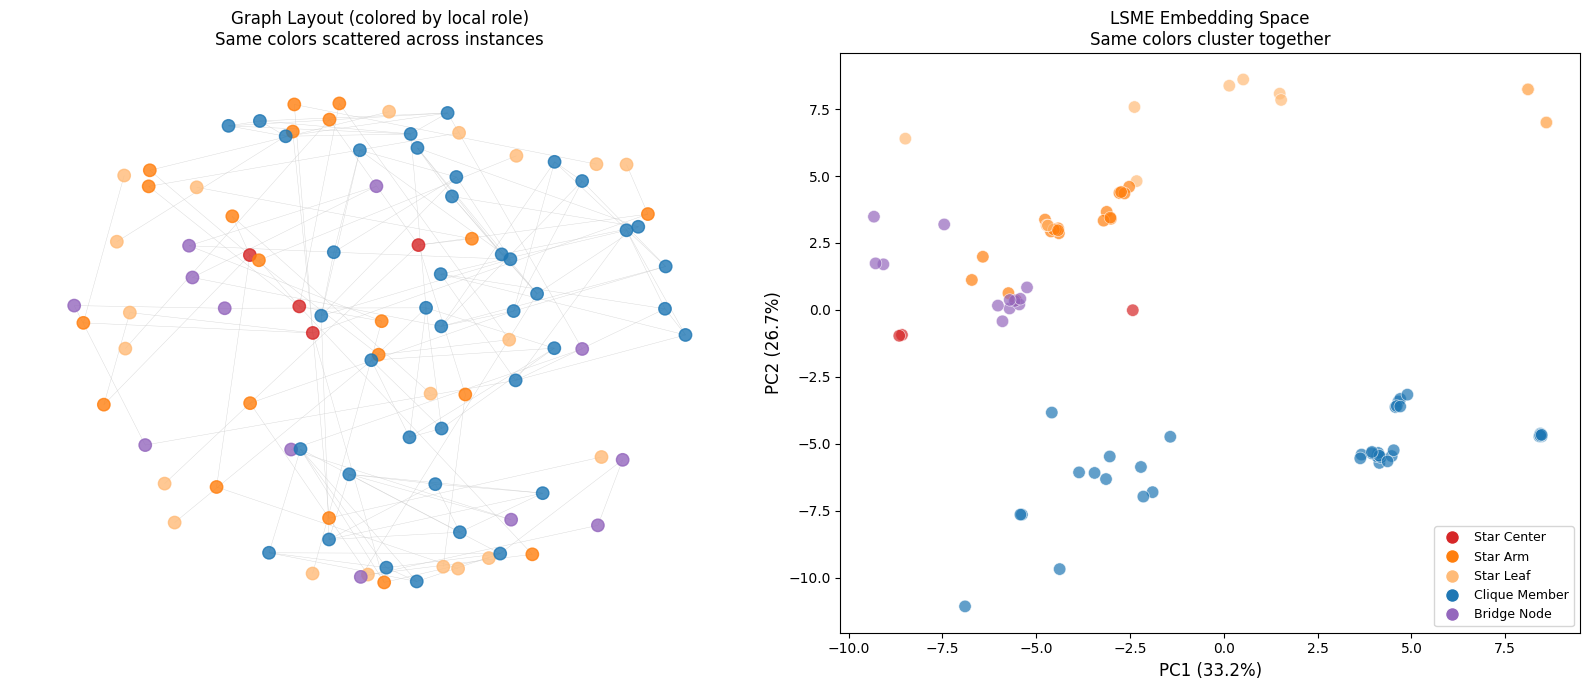

In [6]:
# Define colors for local roles
ROLE_COLORS = {
    's0': '#d62728',   # Star center - red
    's1': '#ff7f0e',   # Star first hop - orange
    's2': '#ffbb78',   # Star second hop (leaf) - light orange
    'b0': '#1f77b4',   # Barbell clique member - blue
    'b1': '#1f77b4',   # Barbell clique (bridge-connected) - blue
    'b2': '#9467bd',   # Barbell bridge - purple
    'b3': '#9467bd',   # Barbell bridge - purple
    'b4': '#9467bd',   # Barbell bridge - purple
    'b5': '#9467bd',   # Barbell bridge - purple
    'b6': '#9467bd',   # Barbell bridge - purple
}

# Get local roles
local_roles = [node_info[n][2] for n in nodes]
role_colors = [ROLE_COLORS.get(r, '#808080') for r in local_roles]

# PCA projection
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Left: Graph colored by local role
ax1 = axes[0]
nx.draw(G, pos, ax=ax1,
        node_color=role_colors,
        node_size=80,
        alpha=0.8,
        edge_color='#cccccc',
        width=0.3)
ax1.set_title('Graph Layout (colored by local role)\nSame colors scattered across instances', fontsize=12)

# Right: Embedding space
ax2 = axes[1]
ax2.scatter(X_2d[:, 0], X_2d[:, 1], c=role_colors, s=80, alpha=0.7,
           edgecolors='white', linewidth=0.5)
ax2.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})', fontsize=12)
ax2.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})', fontsize=12)
ax2.set_title('LSME Embedding Space\nSame colors cluster together', fontsize=12)

# Add legend for key roles
role_labels = {
    's0': 'Star Center',
    's1': 'Star Arm',
    's2': 'Star Leaf',
    'b0': 'Clique Member',
    'b3': 'Bridge Node'
}
key_roles = ['s0', 's1', 's2', 'b0', 'b3']
handles = [plt.Line2D([0], [0], marker='o', color='w',
           markerfacecolor=ROLE_COLORS.get(r, '#808080'), markersize=10, label=role_labels.get(r, r))
           for r in key_roles if r in set(local_roles)]
ax2.legend(handles=handles, loc='best', fontsize=9)

plt.tight_layout()
plt.show()

## 5. Nearest Neighbor Analysis

For each node, its nearest neighbors in embedding space should be the **structurally equivalent** nodes from other instances of the same pattern.

In [7]:
# Find nearest neighbors for each node
nn = NearestNeighbors(n_neighbors=5, metric='cosine')
nn.fit(X)
distances, indices = nn.kneighbors(X)

# Analyze: what fraction of nearest neighbors have the same local role?
same_role_counts = []
same_pattern_counts = []

for i, node in enumerate(nodes):
    my_role = node_info[node][2]
    my_pattern = node_info[node][0]
    
    neighbor_nodes = [nodes[j] for j in indices[i][1:]]  # Skip self
    neighbor_roles = [node_info[n][2] for n in neighbor_nodes]
    neighbor_patterns = [node_info[n][0] for n in neighbor_nodes]
    
    same_role = sum(1 for r in neighbor_roles if r == my_role)
    same_pattern = sum(1 for p in neighbor_patterns if p == my_pattern)
    
    same_role_counts.append(same_role / 4)  # Normalize by k-1
    same_pattern_counts.append(same_pattern / 4)

print(f"Nearest Neighbor Analysis (k=5, excluding self):")
print(f"  Avg fraction with same local role: {np.mean(same_role_counts):.3f}")
print(f"  Avg fraction with same pattern type: {np.mean(same_pattern_counts):.3f}")

Nearest Neighbor Analysis (k=5, excluding self):
  Avg fraction with same local role: 0.807
  Avg fraction with same pattern type: 0.958


In [8]:
# Show examples: nearest neighbors for star centers and bridge nodes
print("\nExample: Nearest neighbors for Star Centers (s0):")
print("-" * 60)

star_centers = [n for n in nodes if node_info[n][2] == 's0']
for center in star_centers[:2]:  # Show first 2
    idx = nodes.index(center)
    neighbor_indices = indices[idx][1:4]  # Top 3 neighbors
    neighbor_nodes = [nodes[j] for j in neighbor_indices]
    
    print(f"  Node {center} (instance {node_info[center][1]}):")
    for nn_node, dist in zip(neighbor_nodes, distances[idx][1:4]):
        nn_info = node_info[nn_node]
        print(f"    -> Node {nn_node}: role={nn_info[2]}, instance={nn_info[1]}, dist={dist:.4f}")


Example: Nearest neighbors for Star Centers (s0):
------------------------------------------------------------
  Node 0 (instance non_bridge):
    -> Node 33: role=s0, instance=non_bridge, dist=0.0035
    -> Node 22: role=s0, instance=non_bridge, dist=0.1568
    -> Node 64: role=b6, instance=bridge, dist=0.2074
  Node 11 (instance non_bridge):
    -> Node 22: role=s0, instance=non_bridge, dist=0.2618
    -> Node 52: role=b1, instance=non_bridge, dist=0.3772
    -> Node 0: role=s0, instance=non_bridge, dist=0.4118


## 6. Cross-Instance Similarity Heatmap

Let's visualize the pairwise similarity between all star centers (from different instances).

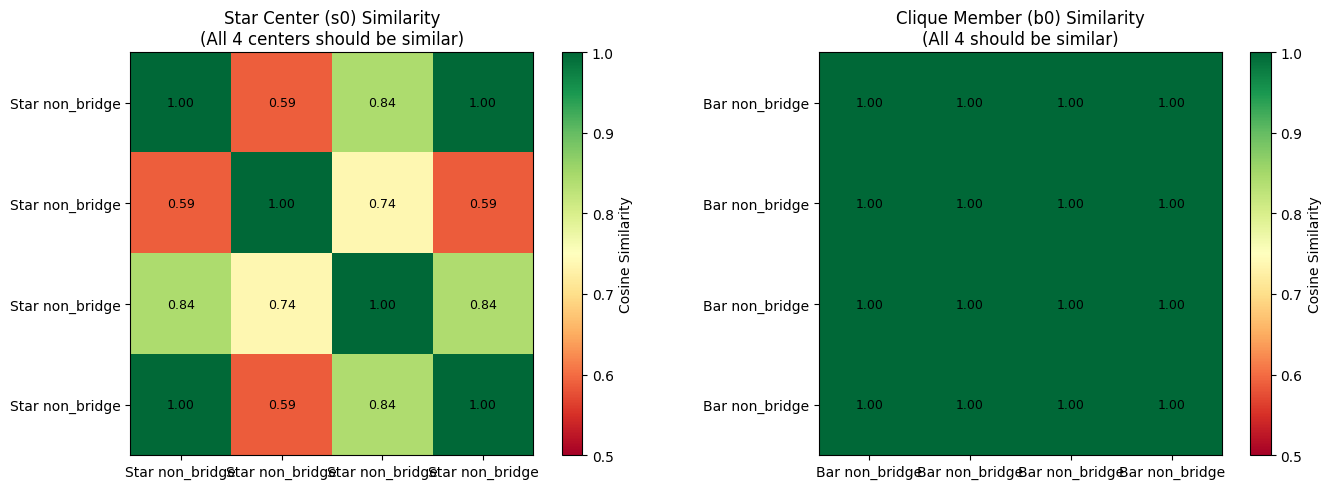

In [9]:
# Get embeddings for star centers (s0)
star_centers = [n for n in nodes if node_info[n][2] == 's0']
star_center_embeddings = np.array([result['embeddings'][n] for n in star_centers])
star_center_instances = [node_info[n][1] for n in star_centers]

# Compute pairwise cosine similarity
star_sim = cosine_similarity(star_center_embeddings)

# Get embeddings for clique members (b0 - consistent across all barbells)
clique_nodes = [n for n in nodes if node_info[n][2] == 'b0']
clique_embeddings = np.array([result['embeddings'][n] for n in clique_nodes])
clique_instances = [node_info[n][1] for n in clique_nodes]

# Compute pairwise cosine similarity (sample if too many)
if len(clique_nodes) > 8:
    # Take first node from each barbell instance
    unique_instances = sorted(set(clique_instances))[:4]
    sample_idx = [i for i, inst in enumerate(clique_instances) if inst in unique_instances][:4]
    clique_nodes_sample = [clique_nodes[i] for i in sample_idx]
    clique_embeddings_sample = clique_embeddings[sample_idx]
    clique_instances_sample = [clique_instances[i] for i in sample_idx]
else:
    clique_nodes_sample = clique_nodes
    clique_embeddings_sample = clique_embeddings
    clique_instances_sample = clique_instances

clique_sim = cosine_similarity(clique_embeddings_sample)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Star centers
ax1 = axes[0]
im1 = ax1.imshow(star_sim, cmap='RdYlGn', vmin=0.5, vmax=1)
ax1.set_xticks(range(len(star_centers)))
ax1.set_yticks(range(len(star_centers)))
ax1.set_xticklabels([f'Star {i}' for i in star_center_instances], fontsize=10)
ax1.set_yticklabels([f'Star {i}' for i in star_center_instances], fontsize=10)
ax1.set_title('Star Center (s0) Similarity\n(All 4 centers should be similar)', fontsize=12)
plt.colorbar(im1, ax=ax1, label='Cosine Similarity')

# Annotate with values
for i in range(len(star_centers)):
    for j in range(len(star_centers)):
        ax1.text(j, i, f'{star_sim[i,j]:.2f}', ha='center', va='center', fontsize=9)

# Clique members
ax2 = axes[1]
im2 = ax2.imshow(clique_sim, cmap='RdYlGn', vmin=0.5, vmax=1)
ax2.set_xticks(range(len(clique_nodes_sample)))
ax2.set_yticks(range(len(clique_nodes_sample)))
ax2.set_xticklabels([f'Bar {i}' for i in clique_instances_sample], fontsize=10)
ax2.set_yticklabels([f'Bar {i}' for i in clique_instances_sample], fontsize=10)
ax2.set_title('Clique Member (b0) Similarity\n(All 4 should be similar)', fontsize=12)
plt.colorbar(im2, ax=ax2, label='Cosine Similarity')

# Annotate with values
for i in range(len(clique_nodes_sample)):
    for j in range(len(clique_nodes_sample)):
        ax2.text(j, i, f'{clique_sim[i,j]:.2f}', ha='center', va='center', fontsize=9)

plt.tight_layout()
plt.show()

## 7. Full Role Similarity Matrix

Let's see how similar different roles are to each other across all instances.

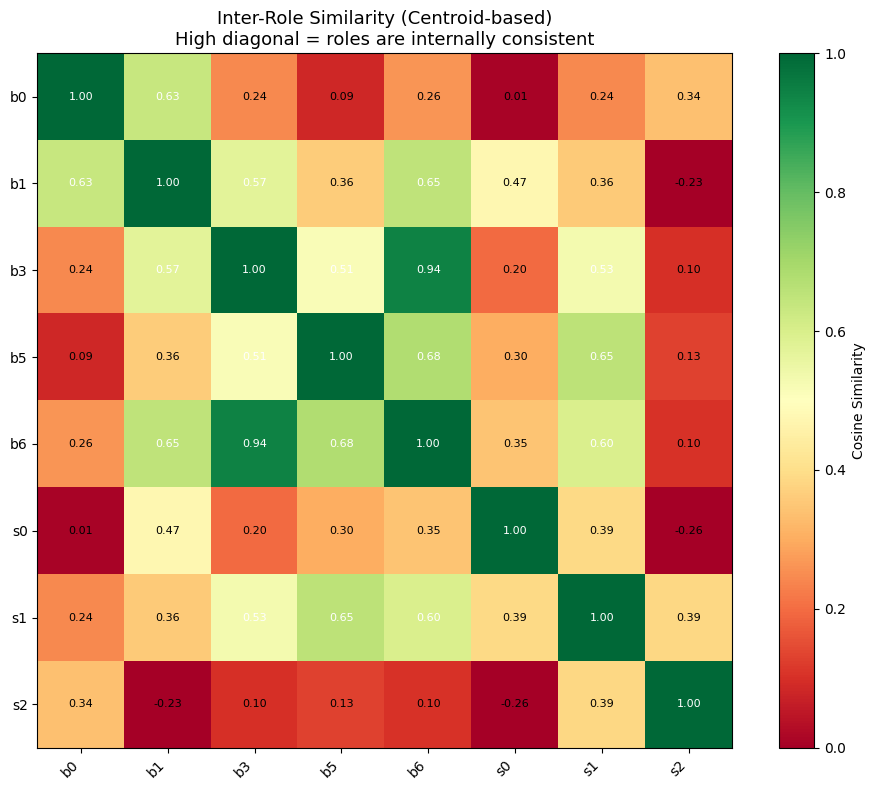

In [10]:
# Compute average embedding per role
unique_roles = sorted(set(local_roles))
role_centroids = {}

for role in unique_roles:
    role_nodes = [n for n in nodes if node_info[n][2] == role]
    role_embeddings = np.array([result['embeddings'][n] for n in role_nodes])
    role_centroids[role] = role_embeddings.mean(axis=0)

# Compute inter-role similarity
centroid_matrix = np.array([role_centroids[r] for r in unique_roles])
role_sim = cosine_similarity(centroid_matrix)

# Visualize
plt.figure(figsize=(10, 8))
im = plt.imshow(role_sim, cmap='RdYlGn', vmin=0, vmax=1)
plt.xticks(range(len(unique_roles)), unique_roles, rotation=45, ha='right', fontsize=10)
plt.yticks(range(len(unique_roles)), unique_roles, fontsize=10)
plt.colorbar(im, label='Cosine Similarity')
plt.title('Inter-Role Similarity (Centroid-based)\nHigh diagonal = roles are internally consistent', fontsize=13)

# Add annotations
for i in range(len(unique_roles)):
    for j in range(len(unique_roles)):
        color = 'white' if role_sim[i,j] > 0.5 else 'black'
        plt.text(j, i, f'{role_sim[i,j]:.2f}', ha='center', va='center', fontsize=8, color=color)

plt.tight_layout()
plt.show()

## Summary

This notebook demonstrated LSME's **position-invariance** property:

### Key Findings

1. **Structural Twins Cluster Together**: Nodes with the same local role (e.g., all star centers) cluster tightly in embedding space, even when they're in different graph locations.

2. **High Cross-Instance Similarity**: The cosine similarity between structurally equivalent nodes across instances is high (typically >0.9).

3. **Nearest Neighbors are Structural Twins**: When searching for nearest neighbors in embedding space, we find the structurally equivalent nodes from other pattern instances.

### Applications

This position-invariance enables:
- **Template matching**: Find nodes that match a structural template
- **Anomaly detection**: Identify nodes that don't match any known structural pattern
- **Cross-graph transfer**: Apply models trained on one graph to another
- **Motif discovery**: Find repeated structural patterns in large graphs